In [1]:
import argparse
import math
import time

import torch
import torch.nn as nn
import DCM_DeepCausal
import numpy as np;
#import importlib
from utils import *;
import Optim
import scipy
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
from numpy import linalg as LA


#default setting

class args:
    data = 'data/syntheticB/filter_norm_expression0.mat'
    graph_path = 'data/syntheticB/groundtruth.mat'
    train = 0.80
    valid = 0.19
    model = 'DCM_DeepCausal'
    
    window = 5
    k_list = [50] #[30,25,20]

    pre_win = 3
    p_list = [20]*6#[20,20,20,20]#[20,20,20,20,20]
    compress_p_list = [50]#[:q40,40]
    clip = 1.
    epochs = 30
    batch_size = 32
    dropout = 0.1
    seed = 12345
    gpu = 0
    save = 'save/model.pt'
    cuda = False
    optim = 'adam'#'adam'
    lr = 0.01
    weight_decay = 0
    horizon = 1

    random_shuffle = True


manualSeed = args.seed
np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)
if args.cuda is True:
    torch.cuda.manual_seed(manualSeed)
    torch.cuda.manual_seed_all(manualSeed)
    torch.backends.cudnn.enabled = False 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


if args.cuda:
     torch.cuda.set_device(args.gpu)
# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
     if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
     else:
        torch.cuda.manual_seed(args.seed)

Data = Data_utility(args)
GroundTruth = sio.loadmat(args.graph_path)['A']
GroundTruth_flat = GroundTruth.reshape(Data.m*Data.m)
print('buliding model')
model = eval(args.model).Model(args, Data);
print(model.linears)

if args.cuda:
    model.cuda()

nParams = sum([p.nelement() for p in model.parameters()])
print('* number of parameters: %d' % nParams)

criterion = nn.MSELoss(size_average=False);#,reduce=False);
if args.cuda:
    criterion = criterion.cuda()

best_val = 10000000;
optim = Optim.Optim(
    model.parameters(), args.optim, args.lr, args.clip, weight_decay = args.weight_decay,
)
test_acc, test_rae, test_corr = 0, 0, 0


def evaluate(loader, data, model, batch_size):
    model.eval()
    total_loss = 0
    n_samples = 0

    for inputs in loader.get_batches(data, batch_size, False):
        X, Y = inputs[0], inputs[1]

        output = model(X);

        loss_org = criterion(output, Y);
        total_loss += loss_org.data.item();
        
        n_samples += (output.size(0) * loader.m);
    
    return total_loss / n_samples


def train(loader, data, model, criterion, optim, batch_size, GroundTruth_flat):
    model.train();
    total_loss = 0;
    mse = 0
    n_samples = 0;
        
    total_time = 0
    
    for inputs in loader.get_batches(data, batch_size, True):        
        begin_time = time.time()
        X, Y = inputs[0], inputs[1]

        model.zero_grad();
        output = model(X);
        loss_org = criterion(output, Y);
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        l2_reg = None
        otg_reg = None

        for layer_i in range(len(model.linears)):
            if not isinstance(model.linears[layer_i], nn.InstanceNorm1d) and not isinstance(model.linears[layer_i], nn.BatchNorm1d):
                W = model.linears[layer_i].weight.transpose(0,1).cpu().detach().numpy()
                ## sparsity
                if W.ndim >=2 and W.shape[0]*W.shape[1]>=100 and model.sparse_label[layer_i]>0: ## sparsity
                    if l2_reg is None:
                        l2_reg = LA.norm(W)
                    else:
                        l2_reg = l2_reg + LA.norm(W)
                ## orthgonality
                if W.ndim >=2 and model.orthgonal_label[layer_i]==1: 
                    if otg_reg is None:
                        otg_reg = LA.norm(np.abs(np.dot(W,np.transpose(W))-np.eye(W.shape[0])))
                    else:
                        otg_reg = otg_reg + LA.norm(np.abs(np.dot(W, np.transpose(W))-np.eye(W.shape[0])))
        
        batch_loss = loss_org + abs(l2_reg)*0.1 + abs(otg_reg)*0.1 
       
        batch_loss.backward()
        total_loss += batch_loss.data.item();
        mse += loss_org.data.item()
        
        total_time = time.time() - begin_time
        
        optim.step()
        n_samples += (output.size(0) * loader.m);
            
    return total_loss / n_samples, mse / n_samples, total_time


print("begin training")
train_loss_set = []
test_loss_set = []
mse_set = []
L1_W_loss_set = []
L1_L_loss_set = []
AUPR = []
AUROC = []

num_weight_plot = min([len(model.linears),50])
weight_norm = np.zeros((args.epochs, num_weight_plot))
aupr_best = 0.1
G_best = np.zeros((model.m, model.m))
weight_matrix = []

for epoch in range(0, args.epochs):
    P_weight=np.zeros(len(args.p_list))
    for j in range(len(args.p_list)):
        P_weight[j] = model.P[j].weight
    weight_matrix.append(P_weight)
    
    train_loss, mse, epoch_time = train(Data, Data.train, model, criterion, optim, args.batch_size, GroundTruth_flat)
    val_loss = evaluate(Data, Data.valid, model, args.batch_size)
    epoch_end_time = time.time()
    
    CGraph = model.predict_relationship()
    CGraph = CGraph.reshape(model.m*model.m)
    precision, recall, threshold = metrics.precision_recall_curve(GroundTruth_flat, CGraph)
    aupr = metrics.auc(recall, precision)
    
    CGraph = CGraph.reshape(model.m*model.m)
    fpr, tpr, thresholds = metrics.roc_curve(GroundTruth_flat, CGraph)   
    auroc = (metrics.auc(fpr, tpr))

    for layer_i in range(num_weight_plot):
        if not isinstance(model.linears[layer_i], nn.InstanceNorm1d):
            tmp = model.linears[layer_i].weight.cpu().detach().numpy()
            if tmp.ndim >2:
                tmp = tmp[:,:,0]
            weight_norm[epoch, layer_i] = LA.norm(tmp)
        
    train_loss_set.append(train_loss)
    test_loss_set.append(val_loss)
    mse_set.append(mse)
    AUPR.append(aupr)
    AUROC.append(auroc)

    print('|end_epoch{:3d}|time:{:5.2f}s|tn_ls {:5.8f}| mse {:5.8f} |vd_ls {:5.4f}|aupr {:5.4f}|auroc {:5.4f}'.format(epoch, epoch_time, train_loss, mse, val_loss, aupr, auroc))
    
    if aupr>=aupr_best:
        G_best = CGraph
               
    if val_loss < best_val:
        best_val = val_loss
        test_loss  = evaluate(Data, Data.test, model, args.batch_size);
        
#plt.figure(figsize=(15,3.5))
plt.figure(1)
plt.imshow(GroundTruth)
plt.figure(2)
plt.imshow(CGraph.reshape((model.m, model.m)))
#plt.subplot(142)
#plt.imshow(G_best)
#plt.subplot(143)
#plt.imshow(CGraph)

data shape (1200, 130)
buliding model
ModuleList(
  (0): Linear(in_features=5, out_features=20, bias=True)
  (1): Linear(in_features=20, out_features=20, bias=True)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Linear(in_features=20, out_features=20, bias=True)
  (6): Linear(in_features=130, out_features=50, bias=False)
  (7): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): SV_Model()
  (9): Linear(in_features=50, out_features=130, bias=False)
  (10): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Linear(in_features=130, out_features=50, bias=False)
  (12): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): SV_Model()
  (14): Linear(in_features=50, out_features=130, bias=False)
  (15): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True,

/Users/chenxiaoxu/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/Users/chenxiaoxu/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


|end_epoch  0|time: 0.17s|tn_ls 2.97673071| mse 2.97193971 |vd_ls 2.9208|aupr 0.0523|auroc 0.6759
|end_epoch  1|time: 0.17s|tn_ls 2.63316124| mse 2.62782122 |vd_ls 2.3732|aupr 0.1348|auroc 0.8211
|end_epoch  2|time: 0.17s|tn_ls 2.20423449| mse 2.19878384 |vd_ls 2.0199|aupr 0.2037|auroc 0.8857
|end_epoch  3|time: 0.17s|tn_ls 1.94749986| mse 1.94188176 |vd_ls 1.8536|aupr 0.2464|auroc 0.9033
|end_epoch  4|time: 0.18s|tn_ls 1.80181249| mse 1.79604342 |vd_ls 1.7656|aupr 0.2659|auroc 0.9162
|end_epoch  5|time: 0.17s|tn_ls 1.71416737| mse 1.70827357 |vd_ls 1.7073|aupr 0.2837|auroc 0.9256
|end_epoch  6|time: 0.16s|tn_ls 1.64776157| mse 1.64172991 |vd_ls 1.6588|aupr 0.2974|auroc 0.9261
|end_epoch  7|time: 0.17s|tn_ls 1.59143659| mse 1.58530048 |vd_ls 1.6223|aupr 0.3120|auroc 0.9283
|end_epoch  8|time: 0.16s|tn_ls 1.55522422| mse 1.54899551 |vd_ls 1.5978|aupr 0.3180|auroc 0.9324
|end_epoch  9|time: 0.17s|tn_ls 1.52290370| mse 1.51657038 |vd_ls 1.5733|aupr 0.3325|auroc 0.9343
|end_epoch 10|time: 

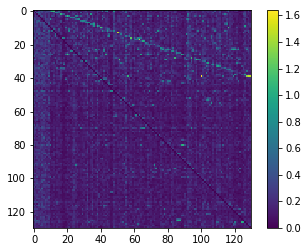

In [2]:
CG1 = model.predict_relationship()
plt.imshow(CG1)
plt.colorbar()

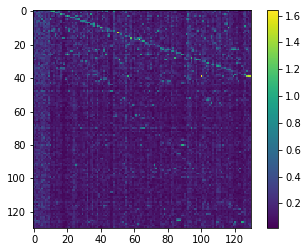

In [3]:
CG2 = model.predict_relationship2()
plt.imshow(CG2)
plt.colorbar()